# Imports

In [2]:
# Data structures and manipulation
import pandas as pd
import numpy as np

# Creating Plots
from plotnine import *  # Python implementation of ggplot
from PIL import Image, ImageDraw, ImageFont
from math import sin, cos, radians, floor, pi


# Color Scheme
The IBM Color Blind Safe Palette.

In [3]:
cs = ["#648FFF","#785EF0", "#DC267F", "#FE6100", "#FFB000"]

# Plotting, varying population

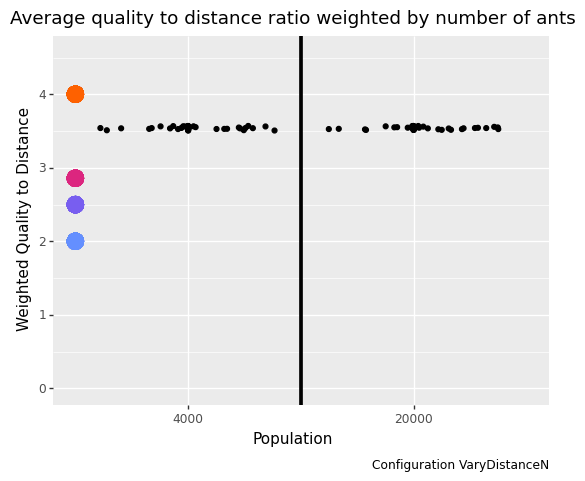

<ggplot: (182540577166)>

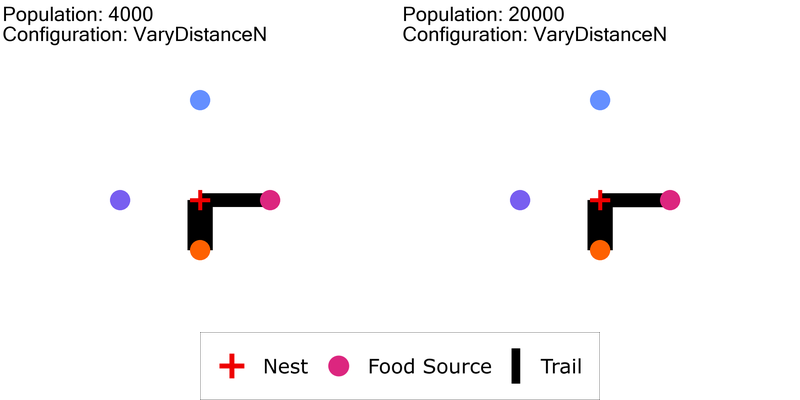

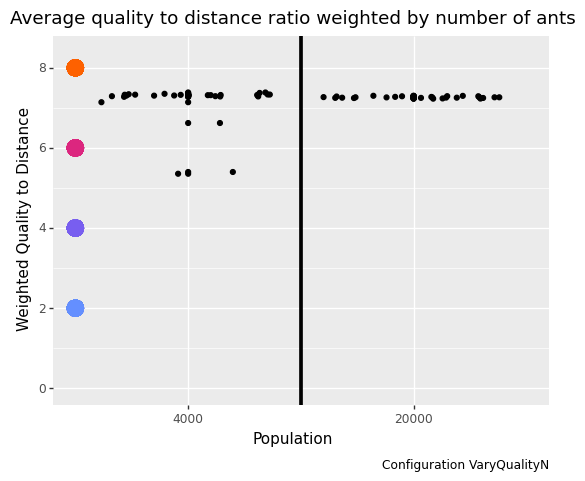

<ggplot: (182545964831)>

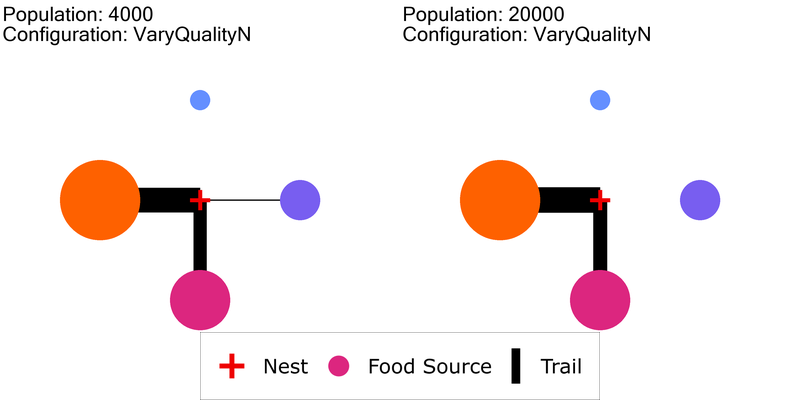

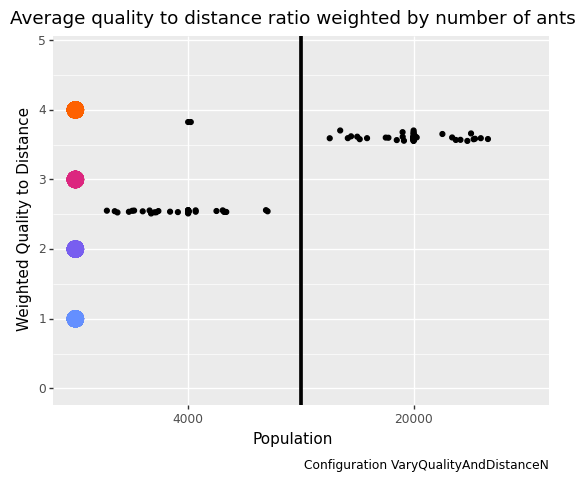

<ggplot: (182543941220)>

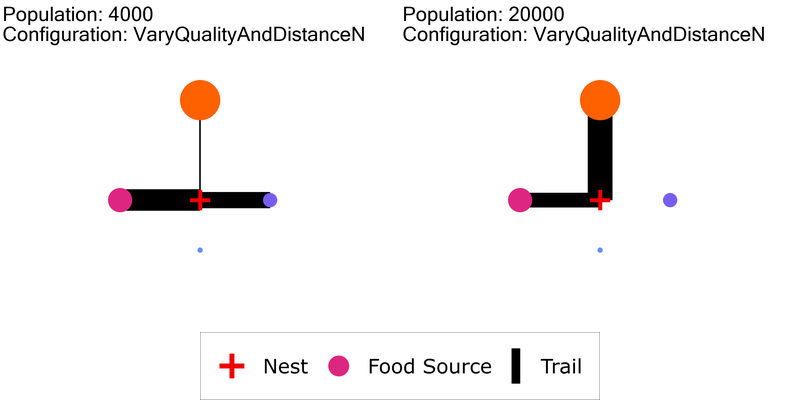

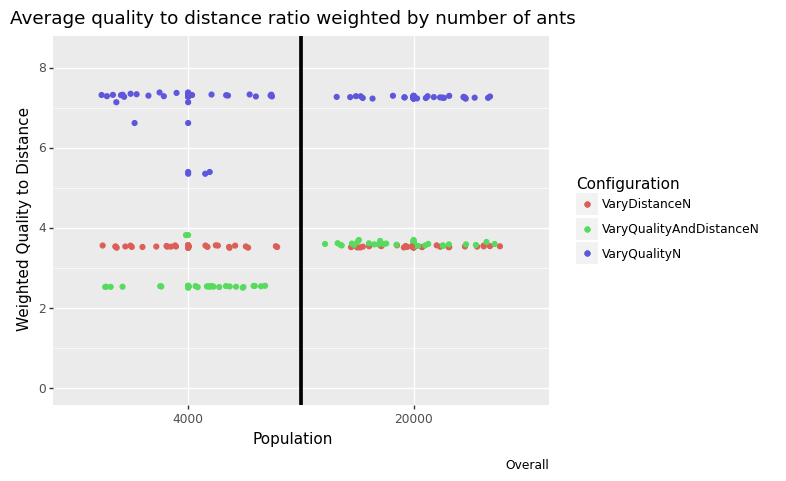

<ggplot: (182546065671)>

In [22]:
# Settings for configuration plots, which depict trail usage, distance, and food sources
SUPERSAMPLE = 4             # By starting with a high-resolution image and then down-scaling, we can simulate anti-aliasing.

WIDTH = 400 * SUPERSAMPLE
HEIGHT = 400 * SUPERSAMPLE

C_X = WIDTH/2
C_Y = HEIGHT/2

NEST_SCALE = 10 * SUPERSAMPLE
NEST_WIDTH = 4 * SUPERSAMPLE
TRAIL_SCALE = 40 * SUPERSAMPLE
QUALITY_SCALE = 10 * SUPERSAMPLE

FONT = ImageFont.truetype("C:\Windows\Fonts\micross.ttf", 20 * SUPERSAMPLE)

# A dictionary to hold the results of all the runs for creating an overall plot at the end
d_overall = {
    "population": np.empty(0),
    "weighted-q-d": np.empty(0),
    "configuration": np.empty(0),
}
configurations = ["VaryDistanceN", "VaryQualityN", "VaryQualityAndDistanceN"]  #The name of the file output by NetLogo, without the .csv extension

for c in configurations:
    # Because this is being run in the notebook, variables don't get reset each time we run the code
    #   so we do it here.
    final_plot = None
    ggdq = None
    plots = []
    
    # The folder holding the output of NetLogo simulations
    results_path = fr"C:\Users\zbtra\Documents\Sophomore\Spring\Research\AntForagingModel\ABResults\FinalSimulations\Paper\{c}.csv"
    df = pd.read_csv(results_path, header=6, index_col=0)
    
    # The structure of df is each column is a food source in a single simulation and the rows are the number
    # of ants at each food source over time along with all the parameter values for the simulation. Since
    # parameter values are originally only input for the first food source, we use the fillna method to 
    # fill in the same values for every other food source in the same simulation.
    df.fillna(method = 'ffill', inplace=True, axis='columns')

    # Calculate weighted quality to distance and average proportion of ants at each source at the final time
    # and save into a dataframe along with the population in each simulation
    w_q_d = np.zeros(df.shape[1]//4)
    q_d = np.zeros(4)
    for i in range(1,5):
        source_i = df.iloc[:, (i-1)::4]  # Get all of the ith food sources across all simulations
        # Below is just a fancy way of calculating (quality / distance) * (final number of ants / total number of ants)
        w_q_d += np.array(source_i.loc[f"pheromone-{i}"].astype(float) / source_i.loc[f"distance-{i}"].astype(float) * 
                          source_i.loc["[final]"].astype(float) / source_i.loc[f"population"].astype(float))
        q_d[i-1] = source_i.loc[f"pheromone-{i}"].astype(float)[i-1] / source_i.loc[f"distance-{i}"].astype(float)[i-1]
    q_d = sorted(q_d)  # Used for putting the food source markers on the weighted quality / distance plot in the right order
    populations = df.loc["population"].unique()
    d = {
        "population": df.iloc[:, 0::4].loc["population"],  # A list of the population in each simulation
        "weighted-q-d": w_q_d    
    }
    df_avg = pd.DataFrame(d)
    
    # Plot weighted quality / distance against population on a scatter plot, see below for an example
    ggqd = (ggplot(df_avg, aes(x="population", y="weighted-q-d")) 
          + geom_point()  # Scatter plot
          + geom_jitter(width = 0.4, height=0)  # Spreads out points horizontally so they are easier to see
          + ylim([0,max(d["weighted-q-d"]) + 1])
          + scale_x_discrete(limits=populations)
          + geom_vline(xintercept=1.5, size=1.5)
          + geom_point(aes(x=.5, y = q_d[3]), color=cs[3], size=6)
          + geom_point(aes(x=.5, y = q_d[2]), color=cs[2], size=6)
          + geom_point(aes(x=.5, y = q_d[1]), color=cs[1], size=6)
          + geom_point(aes(x=.5, y = q_d[0]), color=cs[0], size=6)
          + labs(title = "Average quality to distance ratio weighted by number of ants", 
                 caption = f"Configuration {c}")
          + xlab("Population")
          + ylab("Weighted Quality to Distance"))
    display(ggqd)
    
    # Add the information from this configuration to the overall dataset
    d_overall["population"] = np.append(d_overall["population"], d["population"])
    d_overall["weighted-q-d"] = np.append(d_overall["weighted-q-d"], d["weighted-q-d"])
    d_overall["configuration"] = np.append(d_overall["configuration"], np.array([str(c)] * len(w_q_d)))
    
    # Make a configuration plot for each population size
    runs = df.shape[1] // df.loc["population"].nunique() # Number of runs for each population level
    for p in range(df.loc["population"].nunique()):
        d = {
            "distance": [0] * 4,
            "quality":  [0] * 4,
            "angle":    [0] * 4,
            "avg":      [0] * 4,
            "q-to-d":   [0] * 4
        }
        # Calculate the relevant information for each food source, taking into account every 
        # simulation at this population level
        for i in range(1,5):
            # The average proportion of the total population on a trail to this food source
            d["avg"][i-1] = df.iloc[:, p * runs + (i-1):(p+1) * runs:4].loc["[final]"].astype(float).sum()/(runs // 4) / float(df.loc["population"].unique()[p])  
            d["distance"][i-1] = float(df["1"][f"distance-{i}"])
            d["quality"][i-1]  = float(df["1"][f"pheromone-{i}"])
            d["angle"][i-1] = pi/2 + radians(90 * (1-i))
            d["q-to-d"][i-1] = d["quality"][i-1] / d["distance"][i-1]
        sorted_q_d = sorted(d["q-to-d"])  # Used for assigning the appropriate colors to the food sources
    
        # Create the configuration plot using ImageDraw
        plot = Image.new(mode = "RGB", size = (WIDTH, HEIGHT), color=(255, 255, 255))
        draw = ImageDraw.Draw(plot)
        for i in range(4):
            angle = d["angle"][i]
            dist = d["distance"][i]
            food_X = cos(angle) * dist * C_X
            food_Y = sin(angle) * dist * C_Y
            if floor(d["avg"][i] * TRAIL_SCALE) > 1:
                # Draw the scaled trail lines
                draw.line([(C_X, C_Y), (C_X + food_X, C_Y - food_Y)], width = floor(TRAIL_SCALE * d["avg"][i]), fill=(0,0,0))

            # Draw the scaled and colored food source circles
            qual = d["quality"][i]
            draw.ellipse([(C_X + food_X - QUALITY_SCALE * qual, C_Y - food_Y - QUALITY_SCALE * qual), 
                          (C_X + food_X + QUALITY_SCALE * qual, C_Y - food_Y + QUALITY_SCALE * qual)], 
                         fill=cs[sorted_q_d.index(qual/dist)])
            
        # Draw the nest as a + in the middle
        draw.line([(C_X - NEST_SCALE,C_Y), (C_X + NEST_SCALE, C_Y)], width = NEST_WIDTH, fill=(238,0,0))
        draw.line([(C_X,C_Y - NEST_SCALE), (C_X , C_Y + NEST_SCALE)], width = NEST_WIDTH, fill=(238,0,0))

        # Label the plot
        draw.text((10,10), f"Population: {df.loc['population'].unique()[p]}", (0, 0, 0), font=FONT)
        draw.text((10, 10 + 20 * SUPERSAMPLE), f"Configuration: {c}", (0, 0, 0), font=FONT)
        
        plots += [plot]  # Add the configuration plot image to the list of all the plots
            
            
    # Combine all the configuration plot images and downscale to simulate anti-aliasing.
    final_plot = Image.new('RGB', (len(populations)*WIDTH, HEIGHT))
    for i in range(len(plots)):
        final_plot.paste(plots[i], (WIDTH*i, 0))
    final_plot = final_plot.resize((WIDTH*len(populations)//SUPERSAMPLE, HEIGHT//SUPERSAMPLE), resample=Image.LANCZOS)
    
    # Add the legend
    legend = Image.open(r"C:\Users\zbtra\Documents\Sophomore\Spring\Research\Modeling 2023 Paper\configlegend.png")
    ratio = (WIDTH // SUPERSAMPLE) / legend.size[0]
    legend = legend.resize((int(legend.size[0]*ratio), int(legend.size[1]*ratio)), resample=Image.LANCZOS)
    final_plot.paste(legend, (WIDTH//SUPERSAMPLE - legend.size[0]//2,HEIGHT//SUPERSAMPLE - legend.size[1]))

    display(final_plot)

# Plot the weighted quality / distance data for every configuration
df_overall = pd.DataFrame(d_overall)
ggqd = (ggplot(df_overall, aes(x="population", y="weighted-q-d", color="configuration")) 
      + geom_point()
      + geom_jitter(width = 0.4, height=0)
      + ylim([0,max(df_overall["weighted-q-d"]) + 1])
      + scale_x_discrete(limits=populations)
      + geom_vline(xintercept=1.5, size=1.5)
      + labs(title = "Average quality to distance ratio weighted by number of ants",
           caption = f"Overall",
            color="Configuration")
      + xlab("Population")
      + ylab("Weighted Quality to Distance")
       )
display(ggqd)

## Plotting, varying prob

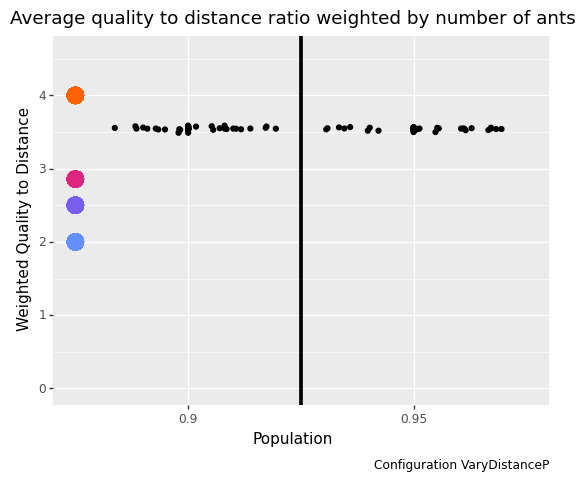

<ggplot: (182543976536)>

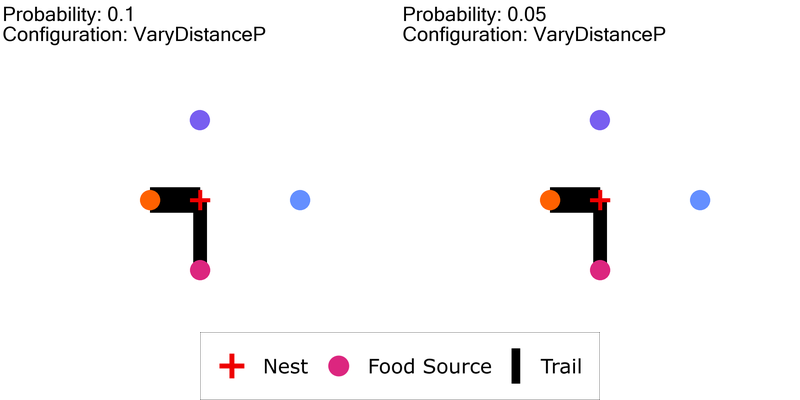

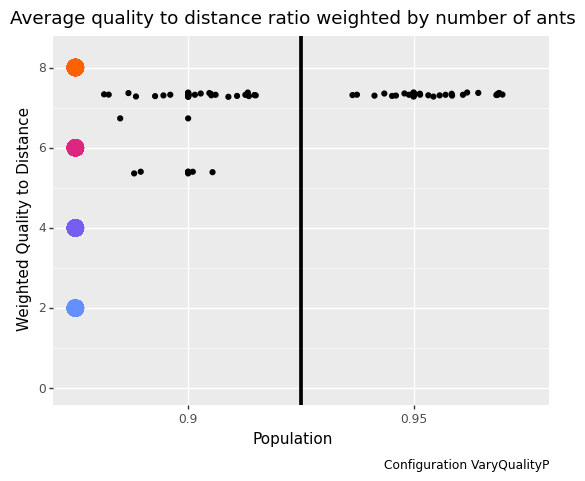

<ggplot: (182544218718)>

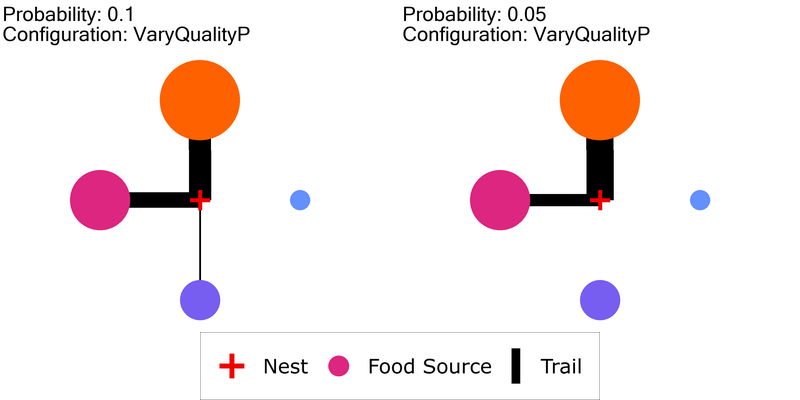

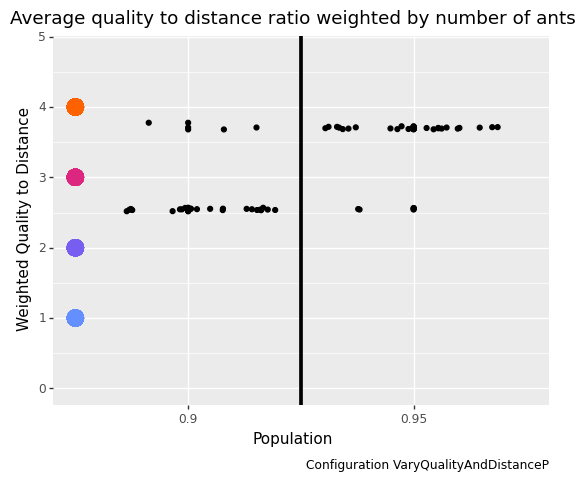

<ggplot: (182539106570)>

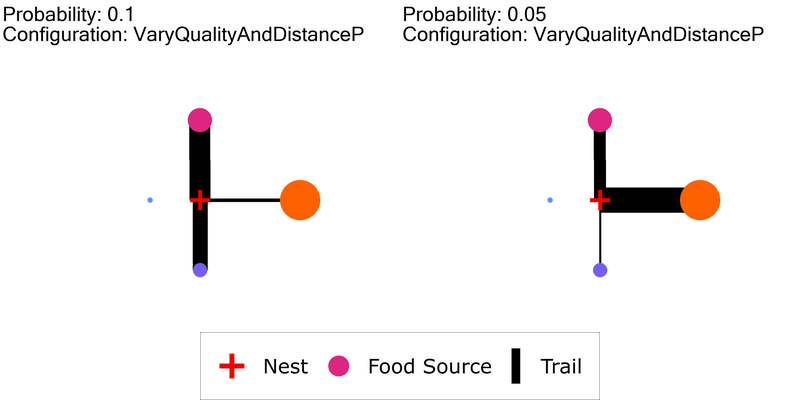

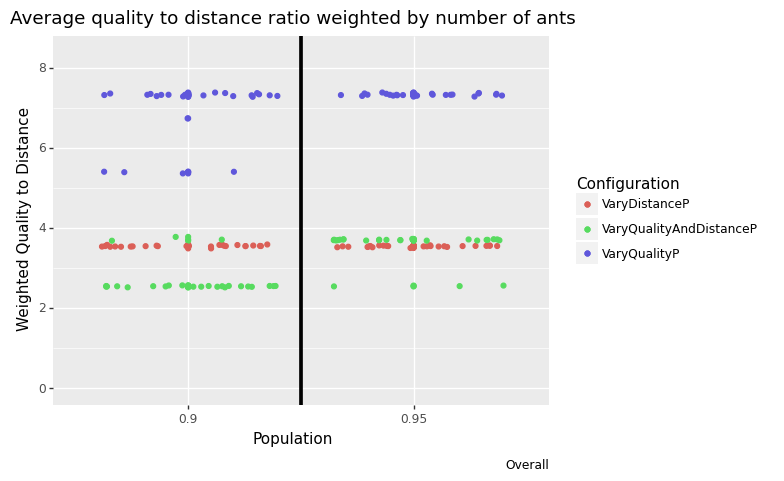

<ggplot: (182546105610)>

In [24]:
# Settings for configuration plots, which depict trail usage, distance, and food sources
SUPERSAMPLE = 4             # By starting with a high-resolution image and then down-scaling, we can simulate anti-aliasing.

WIDTH = 400 * SUPERSAMPLE
HEIGHT = 400 * SUPERSAMPLE

C_X = WIDTH/2
C_Y = HEIGHT/2

NEST_SCALE = 10 * SUPERSAMPLE
NEST_WIDTH = 4 * SUPERSAMPLE
TRAIL_SCALE = 40 * SUPERSAMPLE
QUALITY_SCALE = 10 * SUPERSAMPLE

FONT = ImageFont.truetype("C:\Windows\Fonts\micross.ttf", 20 * SUPERSAMPLE)

# A dictionary to hold the results of all the runs for creating an overall plot at the end
d_overall = {
    "prob": np.empty(0),
    "weighted-q-d": np.empty(0),
    "configuration": np.empty(0),
}
configurations = ["VaryDistanceP", "VaryQualityP", "VaryQualityAndDistanceP"]  #The name of the file output by NetLogo, without the .csv extension

for c in configurations:
    # Because this is being run in the notebook, variables don't get reset each time we run the code
    #   so we do it here.
    final_plot = None
    ggdq = None
    plots = []
    
    # The folder holding the output of NetLogo simulations
    results_path = fr"C:\Users\zbtra\Documents\Sophomore\Spring\Research\AntForagingModel\ABResults\FinalSimulations\Paper\{c}.csv"
    df = pd.read_csv(results_path, header=6, index_col=0)
    
    # The structure of df is each column is a food source in a single simulation and the rows are the number
    # of ants at each food source over time along with all the parameter values for the simulation. Since
    # parameter values are originally only input for the first food source, we use the fillna method to 
    # fill in the same values for every other food source in the same simulation.
    df.fillna(method = 'ffill', inplace=True, axis='columns')

    # Calculate weighted quality to distance and average proportion of ants at each source at the final time
    # and save into a dataframe along with the population in each simulation
    w_q_d = np.zeros(df.shape[1]//4)
    q_d = np.zeros(4)
    for i in range(1,5):
        source_i = df.iloc[:, (i-1)::4]  # Get all of the ith food sources across all simulations
        # Below is just a fancy way of calculating (quality / distance) * (final number of ants / total number of ants)
        w_q_d += np.array(source_i.loc[f"pheromone-{i}"].astype(float) / source_i.loc[f"distance-{i}"].astype(float) * 
                          source_i.loc["[final]"].astype(float) / source_i.loc[f"population"].astype(float))
        q_d[i-1] = source_i.loc[f"pheromone-{i}"].astype(float)[i-1] / source_i.loc[f"distance-{i}"].astype(float)[i-1]
    q_d = sorted(q_d)  # Used for putting the food source markers on the weighted quality / distance plot in the right order
    probs = df.loc["prob"].unique()
    d = {
        "prob": df.iloc[:, 0::4].loc["prob"],  # A list of the population in each simulation
        "weighted-q-d": w_q_d    
    }
    df_avg = pd.DataFrame(d)
    
    # Plot weighted quality / distance against population on a scatter plot, see below for an example
    ggqd = (ggplot(df_avg, aes(x="prob", y="weighted-q-d")) 
          + geom_point()  # Scatter plot
          + geom_jitter(width = 0.4, height=0)  # Spreads out points horizontally so they are easier to see
          + ylim([0,max(d["weighted-q-d"]) + 1])
          + scale_x_discrete(limits=probs)
          + geom_vline(xintercept=1.5, size=1.5)
          + geom_point(aes(x=.5, y = q_d[3]), color=cs[3], size=6)
          + geom_point(aes(x=.5, y = q_d[2]), color=cs[2], size=6)
          + geom_point(aes(x=.5, y = q_d[1]), color=cs[1], size=6)
          + geom_point(aes(x=.5, y = q_d[0]), color=cs[0], size=6)
          + labs(title = "Average quality to distance ratio weighted by number of ants", 
                 caption = f"Configuration {c}")
          + xlab("Population")
          + ylab("Weighted Quality to Distance"))
    display(ggqd)
    
    # Add the information from this configuration to the overall dataset
    d_overall["prob"] = np.append(d_overall["prob"], d["prob"])
    d_overall["weighted-q-d"] = np.append(d_overall["weighted-q-d"], d["weighted-q-d"])
    d_overall["configuration"] = np.append(d_overall["configuration"], np.array([str(c)] * len(w_q_d)))
    
    # Make a configuration plot for each prob
    runs = df.shape[1] // df.loc["prob"].nunique() # Number of runs for each population level
    for p in range(df.loc["prob"].nunique()):
        d = {
            "distance": [0] * 4,
            "quality":  [0] * 4,
            "angle":    [0] * 4,
            "avg":      [0] * 4,
            "q-to-d":   [0] * 4
        }
        # Calculate the relevant information for each food source, taking into account every 
        # simulation at this population level
        for i in range(1,5):
            # The average proportion of the total population on a trail to this food source
            d["avg"][i-1] = df.iloc[:, p * runs + (i-1):(p+1) * runs:4].loc["[final]"].astype(float).sum()/(runs // 4) / float(df.loc["population"].unique()[0])  
            d["distance"][i-1] = float(df["1"][f"distance-{i}"])
            d["quality"][i-1]  = float(df["1"][f"pheromone-{i}"])
            d["angle"][i-1] = pi/2 + radians(90 * (1-i))
            d["q-to-d"][i-1] = d["quality"][i-1] / d["distance"][i-1]
        sorted_q_d = sorted(d["q-to-d"])  # Used for assigning the appropriate colors to the food sources
    
        # Create the configuration plot using ImageDraw
        plot = Image.new(mode = "RGB", size = (WIDTH, HEIGHT), color=(255, 255, 255))
        draw = ImageDraw.Draw(plot)
        for i in range(4):
            angle = d["angle"][i] - pi/2
            dist = d["distance"][i]
            food_X = cos(angle) * dist * C_X
            food_Y = sin(angle) * dist * C_Y
            if floor(d["avg"][i] * TRAIL_SCALE) > 1:
                # Draw the scaled trail lines
                draw.line([(C_X, C_Y), (C_X + food_X, C_Y - food_Y)], width = floor(TRAIL_SCALE * d["avg"][i]), fill=(0,0,0))

            # Draw the scaled and colored food source circles
            qual = d["quality"][i]
            draw.ellipse([(C_X + food_X - QUALITY_SCALE * qual, C_Y - food_Y - QUALITY_SCALE * qual), 
                          (C_X + food_X + QUALITY_SCALE * qual, C_Y - food_Y + QUALITY_SCALE * qual)], 
                         fill=cs[sorted_q_d.index(qual/dist)])
            
        # Draw the nest as a + in the middle
        draw.line([(C_X - NEST_SCALE,C_Y), (C_X + NEST_SCALE, C_Y)], width = NEST_WIDTH, fill=(238,0,0))
        draw.line([(C_X,C_Y - NEST_SCALE), (C_X , C_Y + NEST_SCALE)], width = NEST_WIDTH, fill=(238,0,0))

        # Label the plot
        draw.text((10,10), f"Probability: {round(1-float(df.loc['prob'].unique()[p]),2)}", (0, 0, 0), font=FONT)
        draw.text((10, 10 + 20 * SUPERSAMPLE), f"Configuration: {c}", (0, 0, 0), font=FONT)
        
        plots += [plot]  # Add the configuration plot image to the list of all the plots
            
            
    # Combine all the configuration plot images and downscale to simulate anti-aliasing.
    final_plot = Image.new('RGB', (len(probs)*WIDTH, HEIGHT))
    for i in range(len(plots)):
        final_plot.paste(plots[i], (WIDTH*i, 0))
    final_plot = final_plot.resize((WIDTH*len(probs)//SUPERSAMPLE, HEIGHT//SUPERSAMPLE), resample=Image.LANCZOS)
    
    # Add the legend
    legend = Image.open(r"C:\Users\zbtra\Documents\Sophomore\Spring\Research\Modeling 2023 Paper\configlegend.png")
    ratio = (WIDTH // SUPERSAMPLE) / legend.size[0]
    legend = legend.resize((int(legend.size[0]*ratio), int(legend.size[1]*ratio)), resample=Image.LANCZOS)
    final_plot.paste(legend, (WIDTH//SUPERSAMPLE - legend.size[0]//2,HEIGHT//SUPERSAMPLE - legend.size[1]))

    display(final_plot)

# Plot the weighted quality / distance data for every configuration
df_overall = pd.DataFrame(d_overall)
ggqd = (ggplot(df_overall, aes(x="prob", y="weighted-q-d", color="configuration")) 
      + geom_point()
      + geom_jitter(width = 0.4, height=0)
      + ylim([0,max(df_overall["weighted-q-d"]) + 1])
      + scale_x_discrete(limits=probs)
      + geom_vline(xintercept=1.5, size=1.5)
      + labs(title = "Average quality to distance ratio weighted by number of ants",
           caption = f"Overall",
            color="Configuration")
      + xlab("Population")
      + ylab("Weighted Quality to Distance")
       )
display(ggqd)

# Example Plots
## Weighted quality / distance plot
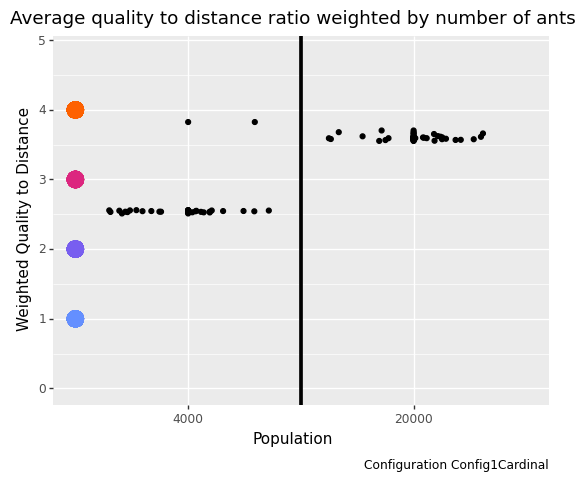

## Configuration plot
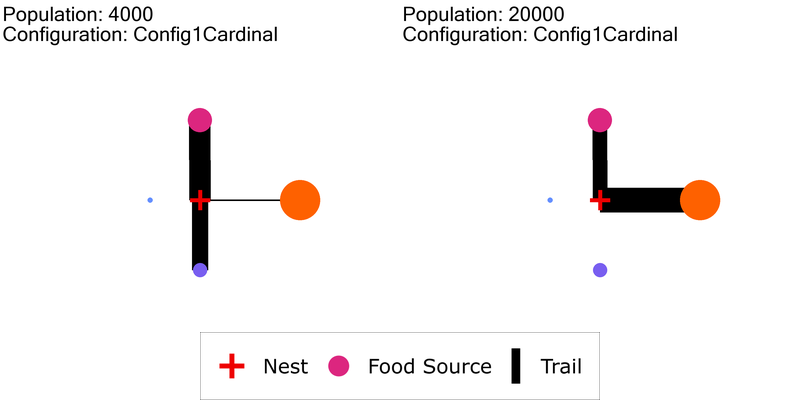